%% [markdown]
## 🔹 FLAN-T5 Finetuning on MMMLU (DE + FR)

**Objective**

This notebook adapts the `google/flan-t5-base` model to answer multiple-choice questions from the German (DE_DE) and French (FR_FR) sections of the MMMLU dataset. The primary goal is to train the model to predict the single correct answer letter.

**Workflow and Key Choices**

The process starts by loading and merging the DE_DE and FR_FR 'test' splits of MMMLU. A key preprocessing step is filtering these examples: only questions where the combined prompt (Question + Choices) is under 256 tokens (as determined by the Flan-T5 tokenizer) are used. This limit is practical for managing the Flan-T5-base model's input size and computational resources.

After filtering, the 'Subject' column is class-encoded to allow for a stratified 80-10-10 split into training, validation, and test sets (using seed 42). Stratification helps ensure that subject distributions are consistent across these datasets, which is beneficial for robust training and evaluation.

Data is then tokenized for a sequence-to-sequence task. The input is a formatted prompt: `Question: {q}\nA) {a}\nB) {b}\nC) {c}\nD) {d}\nAnswer:`. The model is trained to generate the single capital letter corresponding to the correct answer. Dynamic padding during batching is handled by `DataCollatorForSeq2Seq`.

`google/flan-t5-base` was selected due to its strong performance as an instruction-tuned encoder-decoder model, making it suitable for this text-to-text, direct-answer generation task. The finetuning runs for 2 epochs, with a learning rate of 2e-5 and a batch size of 8. All metrics, including baseline accuracy (pre-training) and final accuracy (post-training), are logged using Weights & Biases. A custom `streaming_accuracy` function is employed for evaluation; it checks if the first letter generated by the model matches the true answer.

**Finetuning Process**

* **Task**: This is a supervised sequence-to-sequence finetuning. The model learns to generate the correct answer letter based on the provided question and choices.
* **Loss Function**: The `AutoModelForSeq2SeqLM` (like Flan-T5) uses a **cross-entropy loss**. This loss is computed by comparing the model's predicted probability distribution for tokens with the actual target tokens (the single answer letter).
* **Learning Signal**: The training is driven by minimizing this cross-entropy loss. This process implicitly guides the model to learn the mapping from the input question to the correct answer letter. There isn't an explicit reward signal in the reinforcement learning sense.

This notebook outlines a focused approach to finetuning Flan-T5 for a specific multiple-choice QA format, highlighting data preparation, training, and evaluation tailored to the task.

In [1]:
%env CUDA_LAUNCH_BLOCKING=1
%env TQDM_NOTEBOOK=0

env: CUDA_LAUNCH_BLOCKING=1
env: TQDM_NOTEBOOK=0


In [2]:
# !pip install -q datasets transformers accelerate evaluate wandb scikit-learn seaborn matplotlib sentencepiece

In [3]:
import os, gc, warnings, torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from tqdm import TqdmWarning
from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq,
                          Seq2SeqTrainingArguments, Seq2SeqTrainer)
from sklearn.metrics import accuracy_score, confusion_matrix
import wandb, evaluate

warnings.filterwarnings('ignore', category=TqdmWarning)
warnings.filterwarnings('ignore', message='Passing a tuple of `past_key_values`', category=FutureWarning)

# --- wandb: everything under root/wandb ---
os.environ['WANDB_JUPYTER'] = 'disabled'
wandb_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'wandb'))
os.makedirs(wandb_dir, exist_ok=True)
wandb.init(project='mmmlu_flan_t5_de_fr', name='flan-t5-1epoch', dir=wandb_dir, mode='online')

/home/denis/kpi/iasa_nlp_labs/mmmlu_question_answering/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: denis-katkalo (denis-katkalo-kpi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
model_name = 'google/flan-t5-base'
tokenizer  = AutoTokenizer.from_pretrained(model_name)

In [5]:
# 1  Load DE_DE & FR_FR subsets
de_ds = load_dataset('openai/MMMLU', 'DE_DE', split='test')
fr_ds = load_dataset('openai/MMMLU', 'FR_FR', split='test')
raw_ds = concatenate_datasets([de_ds, fr_ds])

In [ ]:
# 2  Filter examples whose prompt < 256 tokens
def build_prompt(q, a, b, c, d):
    return f'Question: {q}\nA) {a}\nB) {b}\nC) {c}\nD) {d}\nAnswer:'

def length_ok(ex):
    return len(tokenizer(build_prompt(ex['Question'], ex['A'], ex['B'], ex['C'], ex['D'])).input_ids) < 256

filtered_ds = raw_ds.filter(length_ok, num_proc=4)

In [7]:
# 3  Stratified 80-10-10 split
filtered_ds = filtered_ds.class_encode_column('Subject')
tmp = filtered_ds.train_test_split(0.2, seed=42, stratify_by_column='Subject')
train_ds = tmp['train']
rest     = tmp['test'].train_test_split(0.5, seed=42, stratify_by_column='Subject')
val_ds, test_ds = rest['train'], rest['test']
ds = DatasetDict({'train': train_ds, 'validation': val_ds, 'test': test_ds})

In [8]:
# 4  Tokenisation
def preprocess(batch):
    prompts = [build_prompt(q, a, b, c, d) for q, a, b, c, d in zip(
        batch['Question'], batch['A'], batch['B'], batch['C'], batch['D'])]
    enc = tokenizer(prompts, truncation=True)
    enc['labels'] = tokenizer(batch['Answer'], add_special_tokens=False).input_ids
    return enc

tok_ds = ds.map(preprocess, batched=True, remove_columns=ds['train'].column_names)

In [9]:
# 5  Model & Trainer (1 epoch, no val)
model         = AutoModelForSeq2SeqLM.from_pretrained(model_name)
data_collator = DataCollatorForSeq2Seq(tokenizer, model)

outputs_root   = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'outputs'))
train_out_dir  = os.path.join(outputs_root, 'flan_t5_mmmlu_fr_de')
os.makedirs(train_out_dir, exist_ok=True)

args = Seq2SeqTrainingArguments(
    output_dir=train_out_dir,
    run_name='flan_t5_1epoch',
    eval_strategy='no',          # no val during training
    save_strategy='no',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    report_to=['wandb'],
    seed=42)

trainer = Seq2SeqTrainer(model=model,
                        args=args,
                        train_dataset=tok_ds['train'],
                        data_collator=data_collator,
                        tokenizer=tokenizer,
                        compute_metrics=None)

/tmp/ipykernel_10609/993845964.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(model=model,


In [10]:
# --- helper: RAM–safe baseline accuracy -----------------------------------
_letter2id = {"A": 0, "B": 1, "C": 2, "D": 3}

def streaming_accuracy(trainer, dataset):
    dl      = trainer.get_eval_dataloader(dataset)
    metric  = evaluate.load("accuracy")
    model   = trainer.model.eval()

    for batch in dl:
        batch = {k: v.to(trainer.args.device)
                 for k, v in batch.items()
                 if k in ["input_ids", "attention_mask", "labels"]}

        with torch.no_grad():
            gen = model.generate(batch["input_ids"],
                                 attention_mask=batch["attention_mask"],
                                 max_length=4, num_beams=1)

        # decode → first letter → int id
        preds = [_letter2id.get(tokenizer.decode(g, skip_special_tokens=True).strip()[:1], -1)
                 for g in gen]

        refs  = []
        for seq in batch["labels"].cpu().tolist():
            txt = tokenizer.decode([t for t in seq if t != -100],
                                   skip_special_tokens=True).strip()[:1]
            refs.append(_letter2id.get(txt, -1))

        metric.add_batch(predictions=preds, references=refs)

    return metric.compute()
# --------------------------------------------------------------------------

# >>> baseline BEFORE training <<<
baseline = streaming_accuracy(trainer, tok_ds["test"])
print(f"Baseline test accuracy (before training): {baseline['accuracy']:.4f}")
wandb.log({"baseline_test_accuracy": baseline["accuracy"]})


Baseline test accuracy (before training): 0.2833


In [11]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
100,1.511600
200,1.442900
300,1.431500
400,1.413000
500,1.437700
600,1.434400
700,1.413800
800,1.424300
900,1.399400
1000,1.423300


TrainOutput(global_step=4688, training_loss=1.390288294378808, metrics={'train_runtime': 1357.195, 'train_samples_per_second': 27.628, 'train_steps_per_second': 3.454, 'total_flos': 9459500200390656.0, 'train_loss': 1.390288294378808, 'epoch': 2.0})

Overall Accuracy on 2344 questions: 0.3332
Overall Confusion matrix (A/B/C/D rows vs cols):
 [[ 94 202 115 108]
 [ 49 264 132 115]
 [ 78 209 219 126]
 [ 72 204 153 204]]

Accuracy per Subject (sorted lowest to highest):
  high_school_us_history (n=1): 0.0000
  high_school_world_history (n=3): 0.0000
  high_school_statistics (n=38): 0.1316
  econometrics (n=22): 0.1818
  high_school_government_and_politics (n=38): 0.1842
  college_chemistry (n=20): 0.2000
  professional_psychology (n=120): 0.2250
  professional_accounting (n=55): 0.2364
  abstract_algebra (n=20): 0.2500
  high_school_geography (n=40): 0.2500
  high_school_microeconomics (n=47): 0.2553
  prehistory (n=65): 0.2615
  moral_scenarios (n=179): 0.2626
  virology (n=33): 0.2727
  machine_learning (n=22): 0.2727
  elementary_mathematics (n=75): 0.2800
  professional_medicine (n=28): 0.2857
  human_aging (n=45): 0.2889
  world_religions (n=34): 0.2941
  college_physics (n=20): 0.3000
  college_mathematics (n=20): 0.3000
  high_s

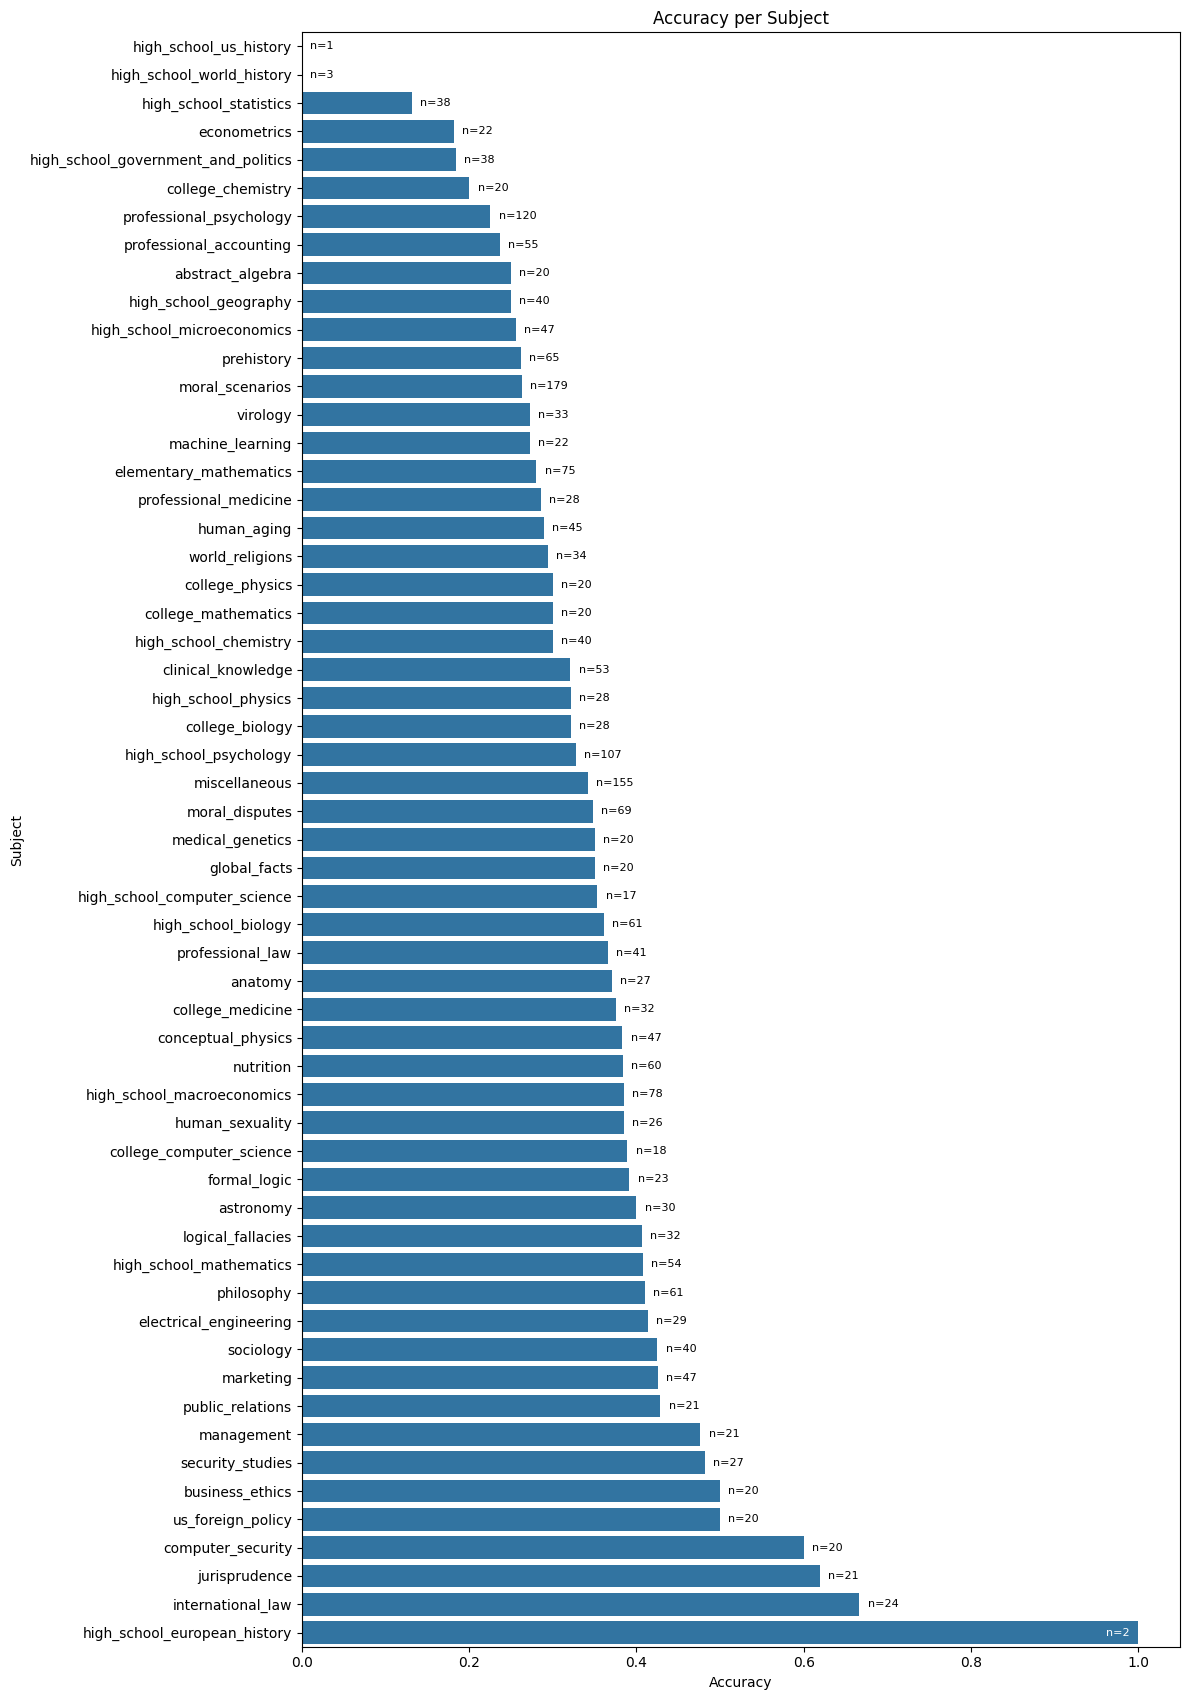

In [12]:
# 6  Evaluate on the held-out test set and display detailed stats
from sklearn.metrics import accuracy_score, confusion_matrix

_letter2id = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

true_labels, pred_labels, subject_ids = [], [], []
model.eval()
dl     = trainer.get_eval_dataloader(tok_ds["test"])
cursor = 0

for batch in dl:
    bsz = batch["input_ids"].size(0)

    batch = {k: v.to(trainer.args.device)
             for k, v in batch.items()
             if k in ["input_ids", "attention_mask", "labels"]}

    with torch.no_grad():
        gen = model.generate(batch["input_ids"],
                             attention_mask=batch["attention_mask"],
                             max_length=4,
                             num_beams=1)

    preds = [tokenizer.decode(g, skip_special_tokens=True).strip()[:1] for g in gen]

    label_seqs = batch["labels"].cpu().tolist()
    refs = [tokenizer.decode([tok for tok in seq if tok != -100],
                             skip_special_tokens=True).strip()[:1]
            for seq in label_seqs]

    pred_labels.extend(preds)
    true_labels.extend(refs)

    subject_ids.extend(test_ds[cursor : cursor + bsz]["Subject"])
    cursor += bsz

# --------- metrics & per-subject analysis ---------
if true_labels:
    # map subject IDs → names
    id2name = ds["test"].features["Subject"].int2str
    subject_names = [id2name(i) for i in subject_ids]

    overall_acc = accuracy_score(true_labels, pred_labels)
    print(f"Overall Accuracy on {len(test_ds)} questions: {overall_acc:.4f}")
    print("Overall Confusion matrix (A/B/C/D rows vs cols):\n",
          confusion_matrix(true_labels, pred_labels, labels=list("ABCD")))

    results_df = pd.DataFrame({
        "Subject": subject_names,
        "TrueLabel": true_labels,
        "PredictedLabel": pred_labels
    })
    results_df["Correct"] = results_df["TrueLabel"] == results_df["PredictedLabel"]

    subject_accuracy = results_df.groupby("Subject")["Correct"].mean().sort_values()  # ascending: worst→best
    subject_counts   = results_df["Subject"].value_counts().reindex(subject_accuracy.index, fill_value=0)

    print("\nAccuracy per Subject (sorted lowest to highest):")
    for subj, acc in subject_accuracy.items():
        print(f"  {subj} (n={subject_counts[subj]}): {acc:.4f}")

    worst_subject, worst_acc = subject_accuracy.index[0], subject_accuracy.iloc[0]
    best_subject,  best_acc  = subject_accuracy.index[-1], subject_accuracy.iloc[-1]
    print(f"\nWorst performing subject: {worst_subject} with accuracy {worst_acc:.4f} "
          f"(n={subject_counts[worst_subject]})")
    print(f"Best performing subject:  {best_subject} with accuracy {best_acc:.4f} "
          f"(n={subject_counts[best_subject]})")

    # horizontal bar plot (worst → best)
    plt.figure(figsize=(12, max(8, len(subject_accuracy) * 0.3)))
    ax = sns.barplot(x=subject_accuracy.values,
                     y=subject_accuracy.index,
                     orient="h")
    plt.xlabel("Accuracy")
    plt.ylabel("Subject")
    plt.title("Accuracy per Subject")
    plt.xlim(0, 1.05)

    for i, bar in enumerate(ax.patches):
        acc_val = bar.get_width()
        subj    = subject_accuracy.index[i]
        cnt     = subject_counts[subj]
        txt_x   = acc_val + 0.01 if acc_val < 0.9 else acc_val - 0.01
        ha      = "left" if acc_val < 0.9 else "right"
        color   = "black" if acc_val < 0.9 else "white"
        ax.text(txt_x, bar.get_y() + bar.get_height()/2,
                f"n={cnt}", ha=ha, va="center",
                fontsize=8, color=color)

    plt.tight_layout()
    plt.show()

    wandb.log({"final_test_accuracy": overall_acc})
else:
    print("No results to display; no samples evaluated.")


#### Potential Struggle with Quantitative/Abstract Subjects:
Excluding the subjects with very few samples, there appears to be a tendency for the model to perform less well on subjects that are highly quantitative or abstract. For example:
* high_school_statistics (n=38) has an accuracy of about 0.13.
* econometrics (n=22) is at about 0.18.
* abstract_algebra (n=20) is at 0.25.
* machine_learning (n=22) shows an accuracy of about 0.27.

#### Better Performance in Some Applied/Humanities/Law-related Subjects:
Again, looking at subjects with a reasonable number of samples, some of the higher accuracies are seen in areas like:
* international_law (n=24) with approximately 0.67 accuracy.
* jurisprudence (n=21) with about 0.62 accuracy.
* computer_security (n=20) with 0.60 accuracy.
* business_ethics (n=20) and us_foreign_policy (n=20) both achieve 0.50 accuracy.
This could indicate the model is relatively better at recalling or reasoning about information in these areas after finetuning.

#### No Strong Distinction by "High School" vs. "College" vs. "Professional" Prefixes 
The chart does not show a clear pattern where subjects prefixed with 'high_school', 'college', or 'professional' consistently outperform or underperform one another. Performance seems more related to the specific subject matter.

#### Overall Modest Improvement
The overall accuracy after 2 epochs of finetuning is 0.3332, up from a baseline of 0.2833. While an improvement, the per-subject accuracies show that this improvement is not uniform, and many subjects still have relatively low scores.